# Data processing steps
## GRanD and Free-flowing Rivers for Africa subset
### 4/26/2021

In [1]:
# Import packages, set working directory
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import fiona 
import geopandas as gpd
import rasterio as rio
import requests
import seaborn as sns
import zipfile 
import earthpy as et

# Set working directory
wrk_dir_path = os.path.join(et.io.HOME,
                      "earth-analytics",
                      "data")
# Conditional statement to set working directory if it exists or create one if it doesn't exist
if os.path.exists(wrk_dir_path):
    os.chdir(wrk_dir_path)
    print("The specified directory exists and is now the working directory")
else:
    os.makedirs(wrk_dir_path)
    os.chdir(wrk_dir_path)
    print("There currently is not a directory", wrk_dir_path,
          "but it is being created and called to be the working directory.")

# GET DATA FOR AFRICA MAP
# Country boundaries
#et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

The specified directory exists and is now the working directory


'C:\\Users\\Owner\\earth-analytics\\data\\earthpy-downloads\\continent-poly'

In [2]:
# Open GRanD data from website
grand = et.data.get_data(url="https://ln.sync.com/dl/bd47eb6b0/anhxaikr-62pmrgtq-k44xf84f-pyz4atkm")
   
with zipfile.ZipFile("GRanD_Version_1_3.zip","r") as zip_ref:
    zip_ref.extractall("temp")
    print('File is unzipped in temp folder') 

File is unzipped in temp folder


In [3]:
# Open Free-Flowing Rivers global data from website
free = et.data.get_data(url="https://ndownloader.figshare.com/files/15090536")
   
with zipfile.ZipFile("Mapping the worlds free-flowing rivers_Data_Geodatabase.zip","r") as zip_ref:
    zip_ref.extractall("temp")
    print('File is unzipped in temp folder') 

File is unzipped in temp folder


Continent names= ['Africa' 'Asia' 'Australia' 'North America' 'Oceania' 'South America'
 'Antarctica' 'Europe']


<AxesSubplot:>

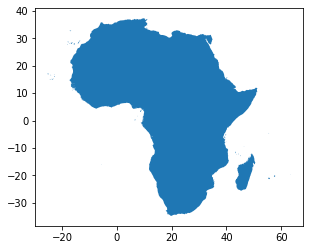

In [4]:
# Import Continent Boundary and Subset for Africa
continent_path = os.path.join("earthpy-downloads", "continent-poly", "Continents.shp")
continent_border = gpd.read_file(continent_path)
print('Continent names=',continent_border['CONTINENT'].unique())

# Select Africa
africa_border = continent_border[continent_border['CONTINENT']=='Africa']
africa_border.plot()

C:\Users\Owner\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Data subset shape (411883, 39)
Dominant pressure factor classes= ['DOF' 'DOR' 'USE' 'URB' 'SED' 'RDD' 'NAN']
Number of observations without River Order = 0
Coordinate reference system of Free-flowing river data epsg:4326


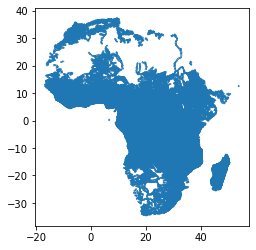

In [5]:
# Free-flowing river data exploration and processing steps
# NOTE: river layer is REALLY big and need to load only portions of it
#       We spoke with Natalie from WWF and she suggested using the following filters
#       Only load river reaches "INC"==1 (Grill et al indicated which reaches they included in their analyses)
#       Can select river reaches with River Order 1-7 - I decided NOT to select by river order until we understand the data better
#       Lauren (previous EA student) suggested working with Africa as a managable area to start with

# Specify bounding box coordinates centered around Africa to load subset of river data
bbox = (-28.476563,-36.173357, 55.195313, 37.857507)

# Path where free-flowing river geodatabase is unzipped
river_path = os.path.join("temp",
                          "Mapping the worlds free-flowing rivers_Data_Geodatabase", 
                          "FFR_river_network.gdb")

free_all = gpd.read_file(river_path,
    bbox=bbox)

# Select river reaches in "Africa" and reaches included in the Grill et al. analysis
free_africa = free_all[free_all['CONTINENT'] == "Africa"]
free_africa = free_africa[free_africa['INC']==1]

free_africa.plot()

print('Data subset shape',free_africa.shape)

# Dominant pressure factor on river connectivity status
print('Dominant pressure factor classes=',free_africa['CSI_D'].unique())

#Number of observations missing River Order (n = 1761 out of 7320)
print('Number of observations without River Order =', free_africa['RIV_ORD'].isnull().sum())

# Coordinate reference system
print('Coordinate reference system of Free-flowing river data', free_africa.crs)


C:\Users\Owner\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


['Senegal' 'Morocco' 'Algeria' 'Mauritania' 'Burkina Faso' 'Mali' 'Ghana'
 'Guinea' 'Ivory Coast' 'Sierra Leone' 'Liberia' 'Tunisia' 'Libya'
 'Nigeria' 'Togo' 'Cameroon' 'Benin' 'Gabon' 'Angola' 'Namibia'
 'Congo (DRC)' 'Zambia' 'Zimbabwe' 'Botswana' 'South Africa' 'Lesotho'
 'Egypt' 'Eritrea' 'Sudan' 'Ethiopia' 'Kenya' 'Uganda' 'Tanzania'
 'Mozambique' 'Swaziland' 'Madagascar' 'Congo']
Irrigation          401
Water supply        135
Hydroelectricity     66
Other                 7
Flood control         4
Recreation            1
Name: MAIN_USE, dtype: int64
Number of observations without main dam use = 146
Coordinate reference system of GRanD data epsg:4326


<AxesSubplot:>

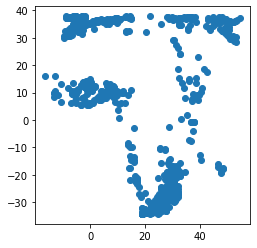

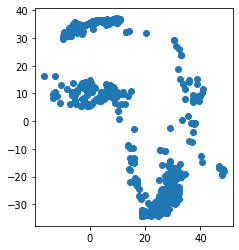

In [20]:
## Subset dam using bounding box
# Specify bounding box coordinates centered around Africa
bbox = (-28.476563,-36.173357, 55.195313, 37.857507)

# Path where geodatabase is unzipped
dam_path = os.path.join("temp",
                        "GRanD_Version_1_3", "GRanD_dams_v1_3.shp")

dam_box = gpd.read_file(dam_path,
    bbox=bbox)

dam_box.plot()

# Select countries in Africa and create new geopandas spatial dataframe
country = ['Algeria','Angola','Benin','Botswana','Burkina Faso','Cameroon','Congo','Congo (DRC)',
           'Egypt','Eritrea','Ethiopia','Gabon','Ghana','Guinea','Ivory Coast','Kenya','Lesotho','Liberia','Libya',
           'Madagascar','Mali','Mauritania','Morocco','Mozambique','Namibia','Nigeria',
           'Senegal','Sierra Leone','South Africa','Sudan','Swaziland','Tanzania','Togo','Tunisia',
           'Uganda','Zambia','Zimbabwe']

dam_africa= dam_box[dam_box['COUNTRY'].isin(country)]

print(dam_africa['COUNTRY'].unique())
print(dam_africa['MAIN_USE'].value_counts())
print('Number of observations without main dam use =', dam_africa['MAIN_USE'].isnull().sum())

# Coordinate reference system
print('Coordinate reference system of GRanD data', dam_africa.crs)

dam_africa.plot()

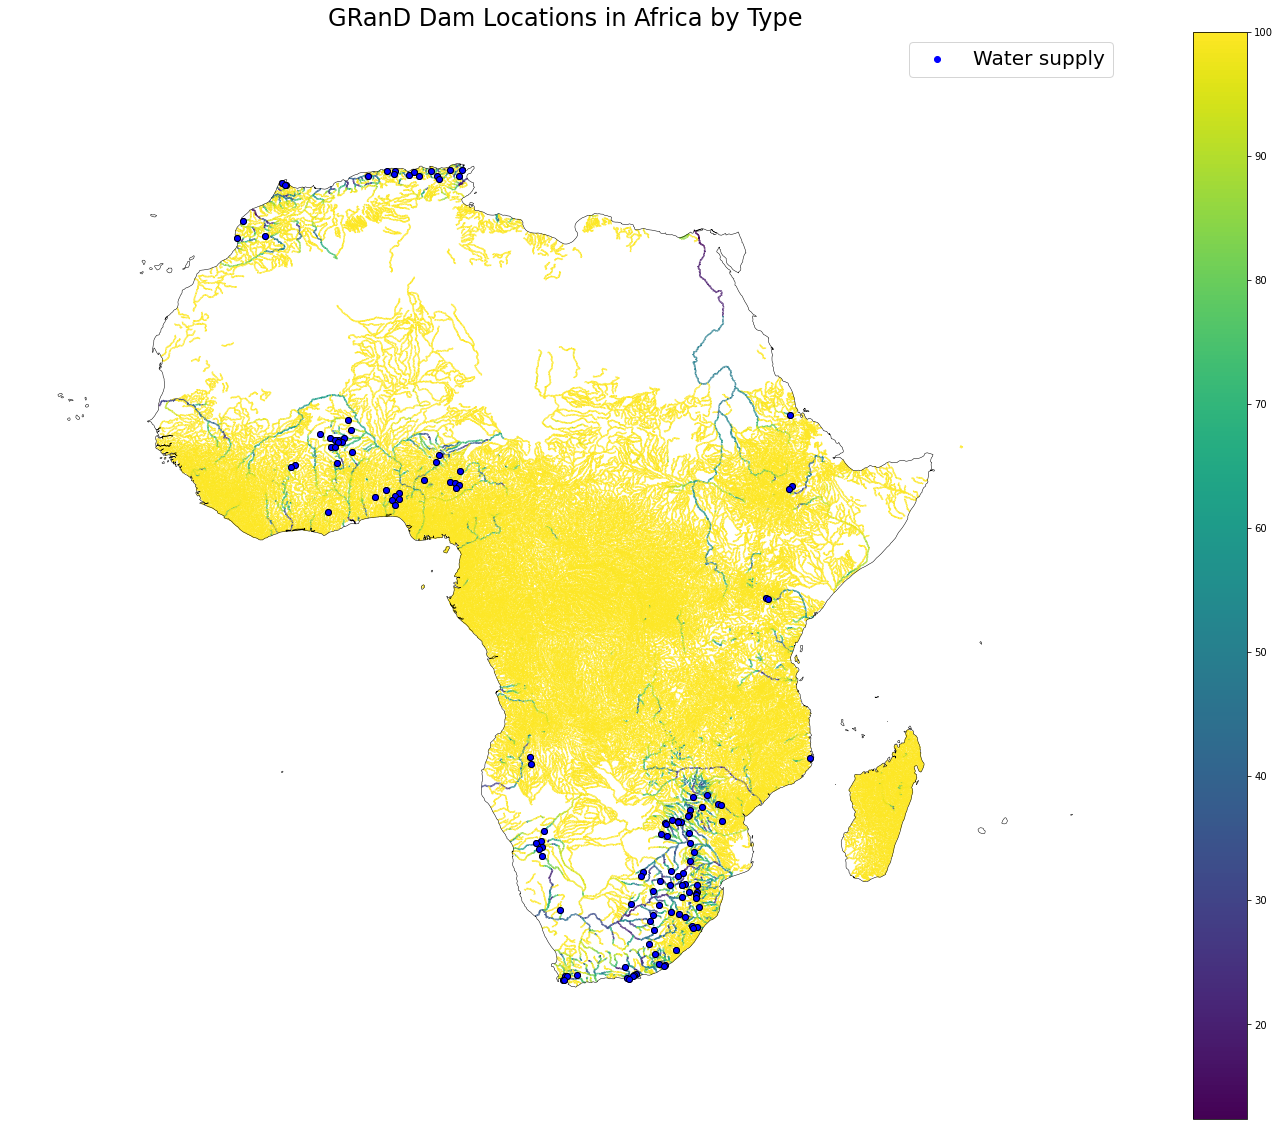

In [25]:
# Map Grand Dam and Africa river
# Create a dictionary with main use
main_use = {'Irrigation': 'black',
            'Hydroelectricity': 'red',
            'Water supply': 'blue',
            'Flood control': 'yellow',
            'Recreation': 'green',
            'Other': 'purple'}

# main_use = {'Irrigation': 'black',
#             'Hydroelectricity': 'brown',
#             'Water supply': 'red',
#             'Flood control': 'yellow',
#             'Recreation': 'green',
#             'Other': 'purple'}

# Korrina's dictionary
# main_use = {'Irrigation': 'black',
#             'Hydroelectricity': 'red',
#             'Water supply': 'blue',
#             'Flood control': 'yellow',
#             'Recreation': 'green',
#             'Other': 'purple',
#             'Navigation': 'orange',
#             'Fisheries': 'pink',
#             'Unknown': 'magenta'}

# Plot the data
fig, ax = plt.subplots(figsize=(25, 20))
free_africa.plot(column='CSI',
                 legend=True,
                 ax=ax, zorder=0)

for ctype, dam_africa in dam_africa.groupby('MAIN_USE'):
    color = main_use[ctype]
    label = ctype
    dam_africa.plot(color=color,
                     ax=ax,
                     label=label)
    
dam_africa.plot(color=color, edgecolor="black", ax=ax,zorder=10)
africa_border.plot(color="none", edgecolor="black", linewidth=.5, ax=ax,zorder=5)

ax.legend()
ax.set_title("GRanD Dam Locations in Africa by Type", fontsize=24)
plt.legend(fontsize=20)
ax.set_axis_off()
plt.axis('equal')
plt.show()

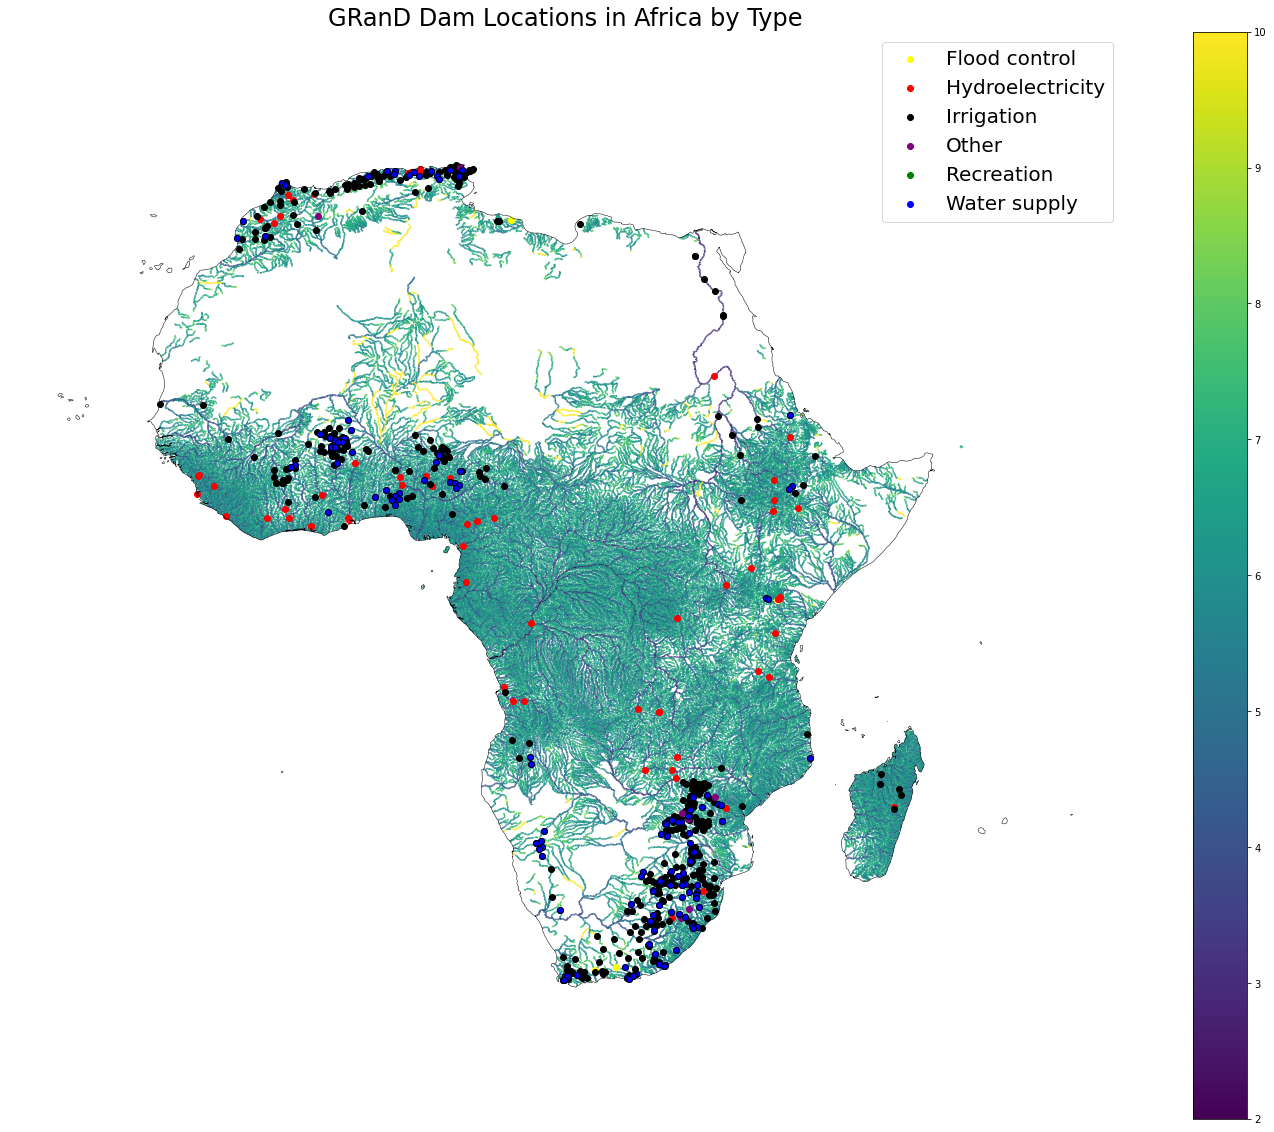

In [23]:
# Map Grand Dam and Africa river
# Create a dictionary with main use
main_use = {'Irrigation': 'black',
            'Hydroelectricity': 'red',
            'Water supply': 'blue',
            'Flood control': 'yellow',
            'Recreation': 'green',
            'Other': 'purple'}

# Plot the data
fig, ax = plt.subplots(figsize=(25, 20))
free_africa.plot(column='RIV_ORD',
                 legend=True,
                 ax=ax, zorder=0)

for ctype, dam_africa in dam_africa.groupby('MAIN_USE'):
    color = main_use[ctype]
    label = ctype
    dam_africa.plot(color=color,
                     ax=ax,
                     label=label)
    
dam_africa.plot(color=color, edgecolor="black", ax=ax,zorder=10)
africa_border.plot(color="none", edgecolor="black", linewidth=.5, ax=ax,zorder=5)

ax.legend()
ax.set_title("GRanD Dam Locations in Africa by Type", fontsize=24)
plt.legend(fontsize=20)
ax.set_axis_off()
plt.axis('equal')
plt.show()

Irrigation          401
Water supply        135
Hydroelectricity     66
Other                 7
Flood control         4
Recreation            1
Name: MAIN_USE, dtype: int64


C:\Users\Owner\miniconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Owner\miniconda3\envs\earth-analytics-python\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[Text(0.5, 1.0, 'Boxplot Natural Log Catchment Area by Dam Type \n in Africa'),
 Text(0.5, 0, 'Dam type'),
 Text(0, 0.5, 'Catchment area sqkm (ln)')]

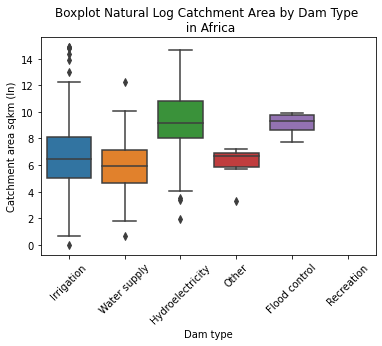

In [22]:
# Plot GRanD attributes
dam_africa_pd = pd.DataFrame(dam_africa)
dam_africa_pd.head
# LN transform catchment area
dam_africa_pd['ln_CATCH_SKM'] = np.log(dam_africa_pd['CATCH_SKM'])
dam_africa_pd['ln_CATCH_SKM'].head()
print(dam_africa_pd['MAIN_USE'].value_counts())

# # Boxplot of watershed area by dam type
# main_use = {'Irrigation': 'black',
#             'Hydroelectricity': 'brown',
#             'Water supply': 'red',
#             'Flood control': 'yellow',
#             'Recreation': 'green',
#             'Other': 'purple'}

fig2, ax2 = plt.subplots()
# for ctype, dam_africa_pd in dam_africa_pd.groupby('MAIN_USE'):
#     color = main_use[ctype]
#     label = ctype
#     sns.boxplot(x="MAIN_USE", y="ln_CATCH_SKM", data=dam_africa_pd,
#                color=color,
#                ax=ax2)
    
ax2 = sns.boxplot(x="MAIN_USE", y="ln_CATCH_SKM", data=dam_africa_pd)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set(title="Boxplot Natural Log Catchment Area by Dam Type \n in Africa",
       xlabel="Dam type",
       ylabel="Catchment area sqkm (ln)")
# ax2.set_title('Catchment Area (ln) by Dam Type')
# ax2.boxplot(x="MAIN_USE", y="ln_CATCH_SKM", data=dam_africa_pd)

In [28]:
free_africa.head()

,REACH_ID,GOID,NOID,NUOID,NDOID,CON_ID,CONTINENT,COUNTRY,BAS_ID,BAS_NAME,...,RDD,FLD,CSI,CSI_D,CSI_FF,CSI_FF1,CSI_FF2,CSI_FFID,Shape_Length,geometry
15,10000016.0,16,16,15_19,21,4,Africa,Tunisia,2612222,,...,1.400,20.000000,25.86560,DOF,0,3,3,16,0.024285,"MULTILINESTRING ((9.50625 37.19792, 9.51458 37..."
18,10000019.0,19,19,20_47,16,4,Africa,Tunisia,2612222,,...,0.000,33.333000,24.40034,DOF,0,3,3,16,0.004167,"MULTILINESTRING ((9.50625 37.19375, 9.50625 37..."
20,10000021.0,21,21,13_16,24,4,Africa,Tunisia,2612222,,...,2.418,38.247002,27.44714,DOF,0,3,3,16,0.120711,"MULTILINESTRING ((9.52708 37.20625, 9.53125 37..."
23,10000024.0,24,24,21_22,28,4,Africa,Tunisia,2612222,,...,0.000,100.000000,32.38239,DOF,0,3,3,16,0.010059,"MULTILINESTRING ((9.62708 37.18125, 9.63125 37..."
27,10000028.0,28,28,24_25,29,4,Africa,Tunisia,2612222,,...,0.000,100.000000,33.94256,DOF,0,3,3,16,0.026011,"MULTILINESTRING ((9.63542 37.17708, 9.63958 37..."


In [24]:
# Export boxplot
# https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib

fig2.savefig('boxplot_damtype_catchment_africa.tiff')